In [16]:
import xarray
import matplotlib.pyplot as plt

In [26]:
indexXr=xarray.merge([
    xarray.open_dataset('results/cmip6EcIndex.nc').sel(year=slice(1850,2098),experiment='ssp585',drop='True'),
    xarray.open_dataset('results/cmip6ssp585TradIndecesTos.nc').sel(year=slice(1850,2098))
])


In [232]:
obsXr=xarray.open_dataset('results/obsIndeces.nc')

In [38]:
from scipy.stats import pearsonr
import numpy as np

In [235]:
modCorLs=list()
for iMod in indexXr.model:

    modelXr=indexXr.sel(model=iMod,drop=True)
    
    years=np.arange(1865,2085)
    rLs=list()
    pLs=list()
    for iYear in years:


        r,p=pearsonr(
            modelXr['cIndex'].sel(year=slice(iYear-15,iYear+14)),
            modelXr['dmi'].sel(year=slice(iYear-15,iYear+14))
        )
        rLs.append(r)
        pLs.append(p)

    modCorLs.append(
        xarray.DataArray([rLs,pLs],
                     dims=['data','year'],
                     coords={
                         'data':['r','p'],
                         'year':years,
                         'model':iMod
                     }
                    ).to_dataset('data')
    )


correlationsXr=xarray.concat(modCorLs,'model')

In [236]:
years=np.arange(1957+15,2000)
rLs=list()
pLs=list()
for iYear in years:


    r,p=pearsonr(
        obsXr['cIndex'].sel(year=slice(iYear-15,iYear+14)),
        obsXr['dmi'].sel(year=slice(iYear-15,iYear+14))
    )
    rLs.append(r)
    pLs.append(p)

obsCorXr=(
    xarray.DataArray([rLs,pLs],
                 dims=['data','year'],
                 coords={
                     'data':['r','p'],
                     'year':years,
                 }
                ).to_dataset('data')
)


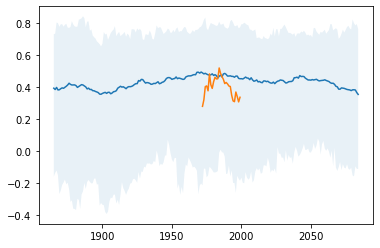

In [239]:
plotData=correlationsXr['r']

#blue line for multi-experiment mean, and light blue shading between min and max
plt.plot(
    plotData.year.values, 
    plotData.mean('model').values, 
    #label=indexToPlot[i], 
    #color=mainColor[i], 
)
plt.fill_between(
    plotData.year.values, 
    plotData.min('model').values, 
    plotData.max('model').values, 
#    color=mainColor[i], 
    alpha=0.1
)

plt.plot(
    obsCorXr.year.values, 
    obsCorXr.r.values, 
    #label=indexToPlot[i], 
    #color=mainColor[i], 
)

